<a href="https://colab.research.google.com/github/Bensmail-anis/developing-gpt2-124M-from-scratch/blob/main/notebooks/Developing_GPT2_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Language models have become fundamental components of modern natural language processing (NLP) systems, powering applications ranging from machine translation to conversational agents and content generation.

In this project,we build the GPT-2 (124M) architecture, and present the training process and performance analysis. Our work is grounded in the theoretical and empirical insights drawn from key publications in the field, including Attention Is All You Need (Vaswani et al., 2017), Language Models are Few-Shot Learners (Brown et al., 2020), and Language Models are Unsupervised Multitask Learners (Radford et al., 2019).

We adopt a systematic approach to elucidate the architecture, training methodology, and capabilities of the GPT-2 model.

The Transformer architecture, introduced by Vaswani et al. (2017), serves as the foundation of GPT-2, leveraging self-attention mechanisms to capture intricate relationships within textual data. This architecture not only enables efficient parallelization during training but also endows the model with the capacity to generate coherent and contextually relevant text across diverse tasks.

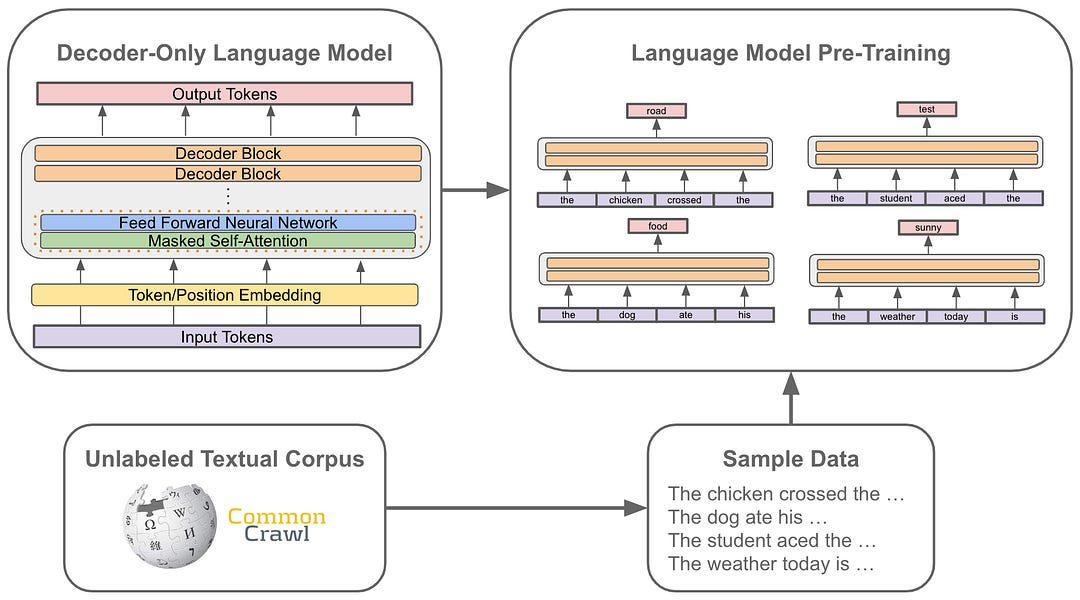

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Dataset Acquisition and Tokenization

In this section, we describe the process of acquiring and tokenizing the FineWeb-Edu dataset, a large-scale corpus containing 10 billion tokens. This dataset is optimized for educational purposes and serves as the foundation for training our GPT-2 model. The dataset, known for its extensive coverage of diverse text sources, is particularly suitable for pretraining models in unsupervised settings.

The dataset is accessed and processed using Google Drive for persistent storage. We utilize a shard-based approach, where each shard contains 100 million tokens, resulting in 100 shards in total. This partitioning strategy ensures efficient loading and processing of the data.

The tokenization process employs the GPT-2 tokenizer, which maps textual content into a sequence of integer tokens. This step is crucial for transforming raw text into a machine-readable format, aligning with the transformer architecture's input requirements. The tokenizer applies a special end-of-text token (<|endoftext|>) at the beginning of each document to delineate textual boundaries.

To manage computational resources effectively, we utilize multiprocessing, allocating half of the available CPU cores to parallelize the tokenization task. This approach significantly accelerates the processing of the dataset while maintaining a balanced resource usage profile.

The resulting tokenized data is stored in .npy format within Google Drive, facilitating seamless integration into subsequent training stages. By leveraging the FineWeb-Edu dataset, we establish a robust foundation for the model's linguistic capabilities, preparing it for diverse NLP tasks without task-specific supervision.

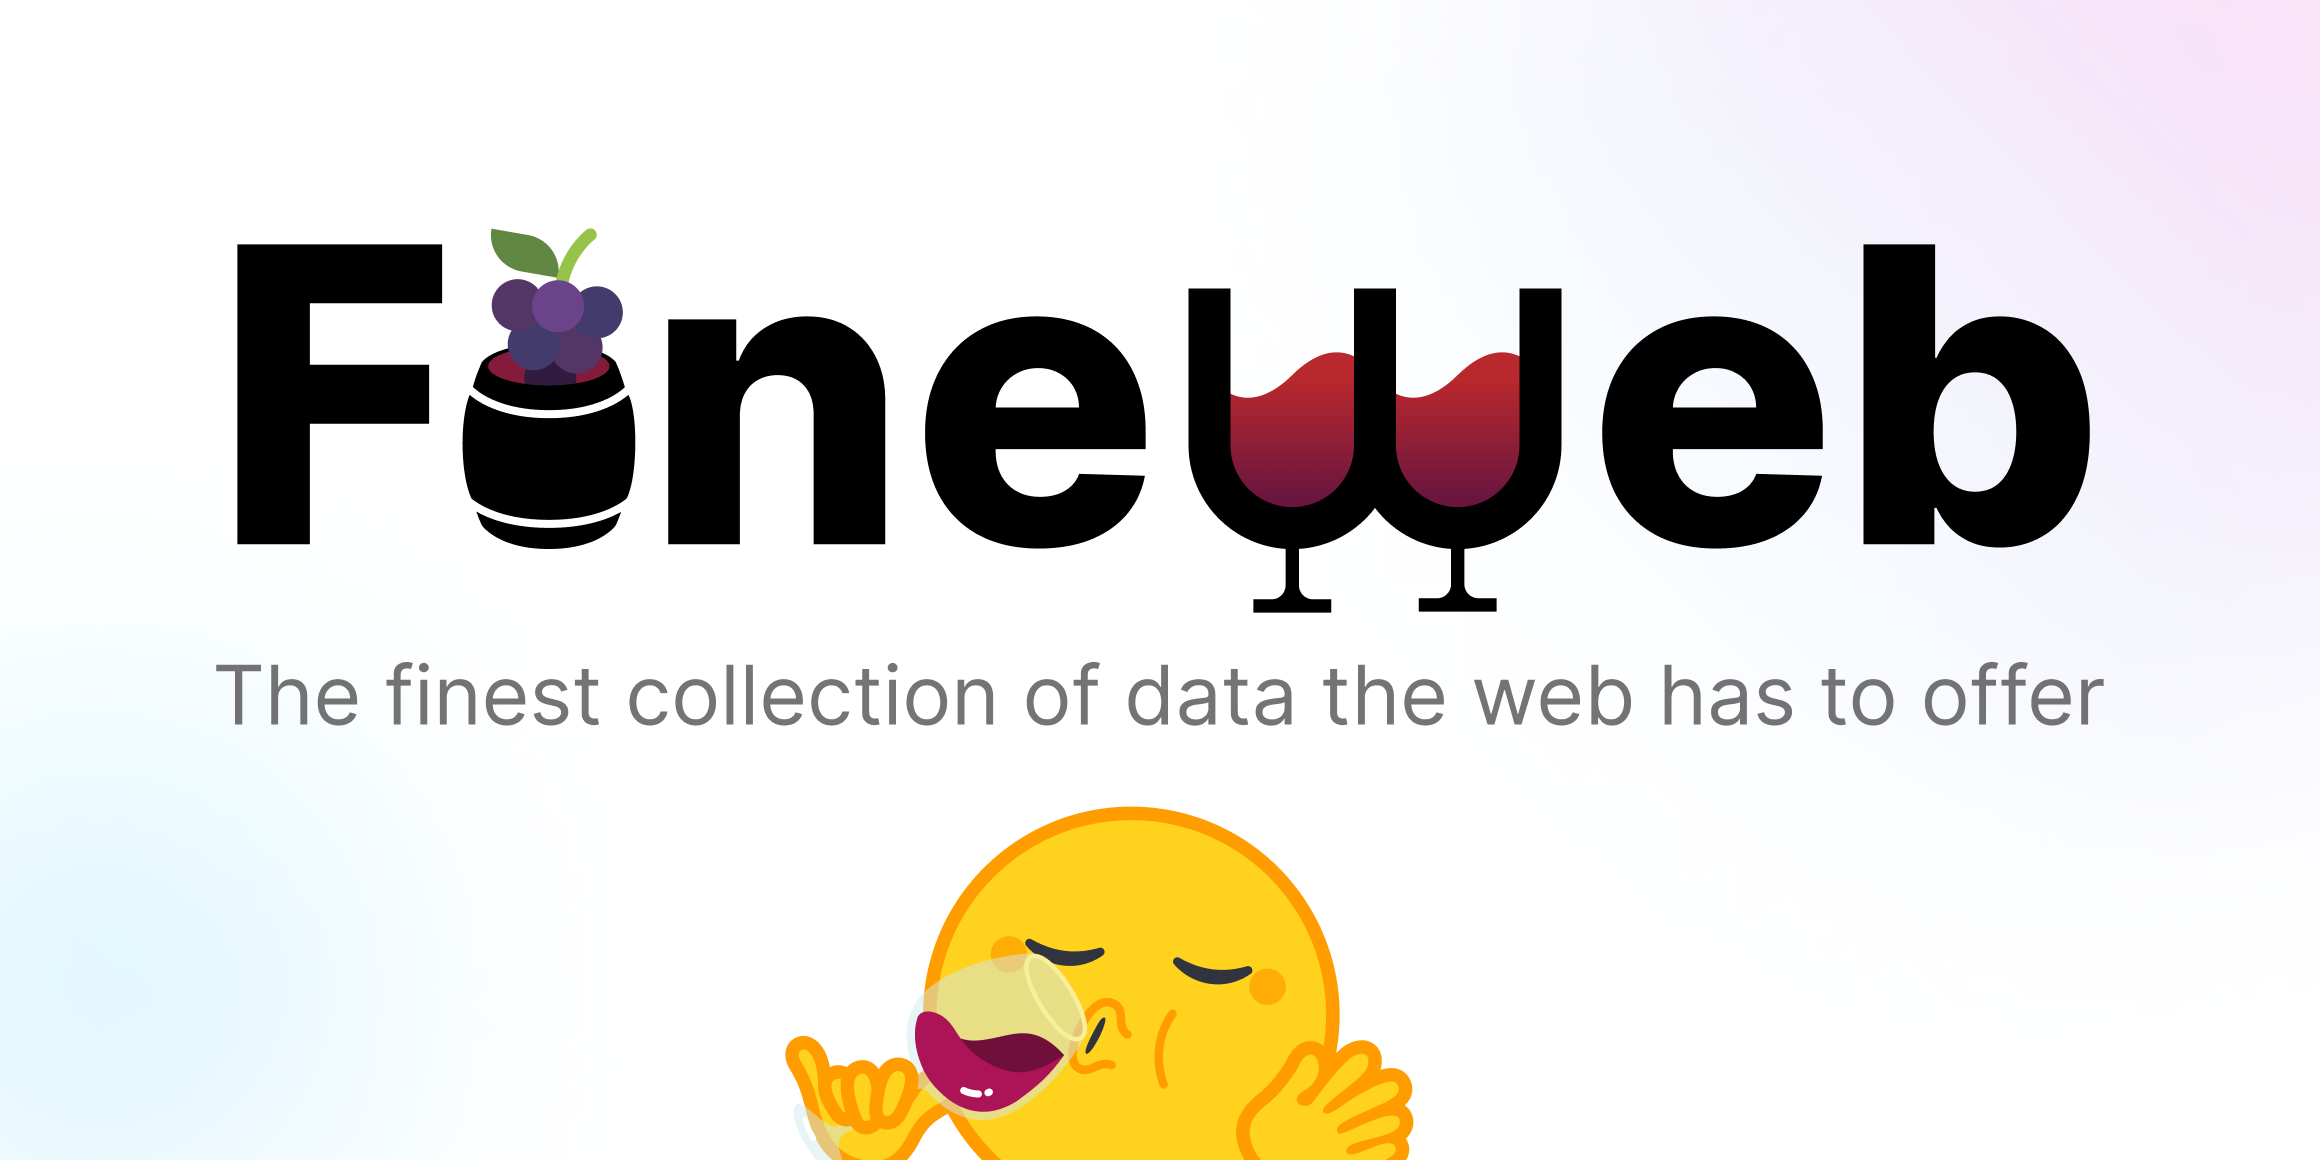

In [ ]:
import os
import multiprocessing as mp
import numpy as np
import tiktoken
from datasets import load_dataset  # pip install datasets
from tqdm import tqdm  # pip install tqdm
from google.colab import drive  # For Google Drive storage

# ------------------------------------------
# 🔹 MOUNT GOOGLE DRIVE FOR PERSISTENT STORAGE
drive.mount('/content/drive')

# 🔹 DEFINE STORAGE PATHS
BASE_DIR = "/content/drive/MyDrive/edu_fineweb10B"  # Saves in Google Drive
os.makedirs(BASE_DIR, exist_ok=True)

REMOTE_NAME = "sample-10BT"
SHARD_SIZE = int(1e8)  # 100M tokens per shard, total of 100 shards

# 🔹 DOWNLOAD DATASET
fw = load_dataset("HuggingFaceFW/fineweb-edu", name=REMOTE_NAME, split="train")

# 🔹 INITIALIZE TOKENIZER
enc = tiktoken.get_encoding("gpt2")
eot = enc._special_tokens['<|endoftext|>']  # End-of-text token

def tokenize(doc):
    """Tokenizes a single document and returns a numpy array of uint16 tokens."""
    tokens = [eot]  # Start with <|endoftext|>
    tokens.extend(enc.encode_ordinary(doc["text"]))
    tokens_np = np.array(tokens, dtype=np.uint16)
    return tokens_np

def write_datafile(filename, tokens_np):
    """Saves tokenized data to disk."""
    np.save(filename, tokens_np)

# 🔹 MULTIPROCESSING TOKENIZATION
num_cpus = os.cpu_count()
num_workers = max(1, num_cpus // 2)  # Use half available CPUs for balance

with mp.Pool(num_workers) as pool:
    shard_index = 0
    all_tokens_np = np.empty((SHARD_SIZE,), dtype=np.uint16)
    token_count = 0
    progress_bar = tqdm(total=SHARD_SIZE, unit="tokens", desc=f"Shard {shard_index}", leave=True)

    for tokens in pool.imap(tokenize, fw, chunksize=64):  # 🔹 INCREASED CHUNKSIZE FOR SPEED

        if token_count + len(tokens) < SHARD_SIZE:
            all_tokens_np[token_count : token_count + len(tokens)] = tokens
            token_count += len(tokens)
            progress_bar.update(len(tokens))
        else:
            # Write the full shard
            split = "val" if shard_index == 0 else "train"
            filename = os.path.join(BASE_DIR, f"edufineweb_{split}_{shard_index:06d}.npy")
            remainder = SHARD_SIZE - token_count
            progress_bar.update(remainder)
            all_tokens_np[token_count : token_count + remainder] = tokens[:remainder]
            write_datafile(filename, all_tokens_np)

            # Start new shard
            shard_index += 1
            progress_bar = tqdm(total=SHARD_SIZE, unit="tokens", desc=f"Shard {shard_index}", leave=True)
            all_tokens_np[: len(tokens) - remainder] = tokens[remainder:]
            token_count = len(tokens) - remainder

    # Save last shard if it has remaining tokens
    if token_count > 0:
        split = "val" if shard_index == 0 else "train"
        filename = os.path.join(BASE_DIR, f"edufineweb_{split}_{shard_index:06d}.npy")
        write_datafile(filename, all_tokens_np[:token_count])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


README.md:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

000_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

001_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

002_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

003_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

004_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

005_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

006_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

007_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

008_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

009_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

010_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

011_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

012_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

013_00000.parquet:   0%|          | 0.00/541M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9672101 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/98 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Shard 20: 100%|█████████▉| 99997912/100000000 [00:15<00:00, 6432283.76tokens/s]

Shard 22: 100%|█████████▉| 99997168/100000000 [00:15<00:00, 6591876.97tokens/s]

Shard 24: 100%|█████████▉| 99994716/100000000 [00:15<00:00, 6292363.38tokens/s]

Shard 26: 100%|█████████▉| 99994587/100000000 [00:14<00:00, 6718925.34tokens/s]

Shard 28: 100%|█████████▉| 99999394/100000000 [00:15<00:00, 6559431.59tokens/s]

Shard 30: 100%|█████████▉| 99999935/100000000 [00:15<00:00, 6388152.08tokens/s]

Shard 32: 100%|█████████▉| 99966920/100000000 [00:15<00:00, 6659064.82tokens/s]

Shard 34: 100%|█████████▉| 99999699/100000000 [00:15<00:00, 6562682.10tokens/s]

Shard 36: 100%|█████████▉| 99993819/100000000 [00:15<00:00, 6535741.63tokens/s]

Shard 38: 100%|█████████▉| 99999506/100000000 [00:15<00:00, 6486542.99tokens/s]

Shard 40: 100%|█████████▉| 99999686/100000000 [00:14<00:00, 6708876.28tokens/s]

Shard 42: 100%|█████████▉| 9998

## Dataset Construction

The FineWeb-Edu dataset was constructed through a systematic web scraping process, targeting high-quality educational content across diverse domains.

The data sources include publicly available academic articles, educational websites, and open-access research papers. A rigorous filtering pipeline was employed to ensure the quality and relevance of the collected text. This pipeline involved removing duplicate content, eliminating non-text elements, and applying heuristic-based and machine learning-driven filters to retain educationally significant text.

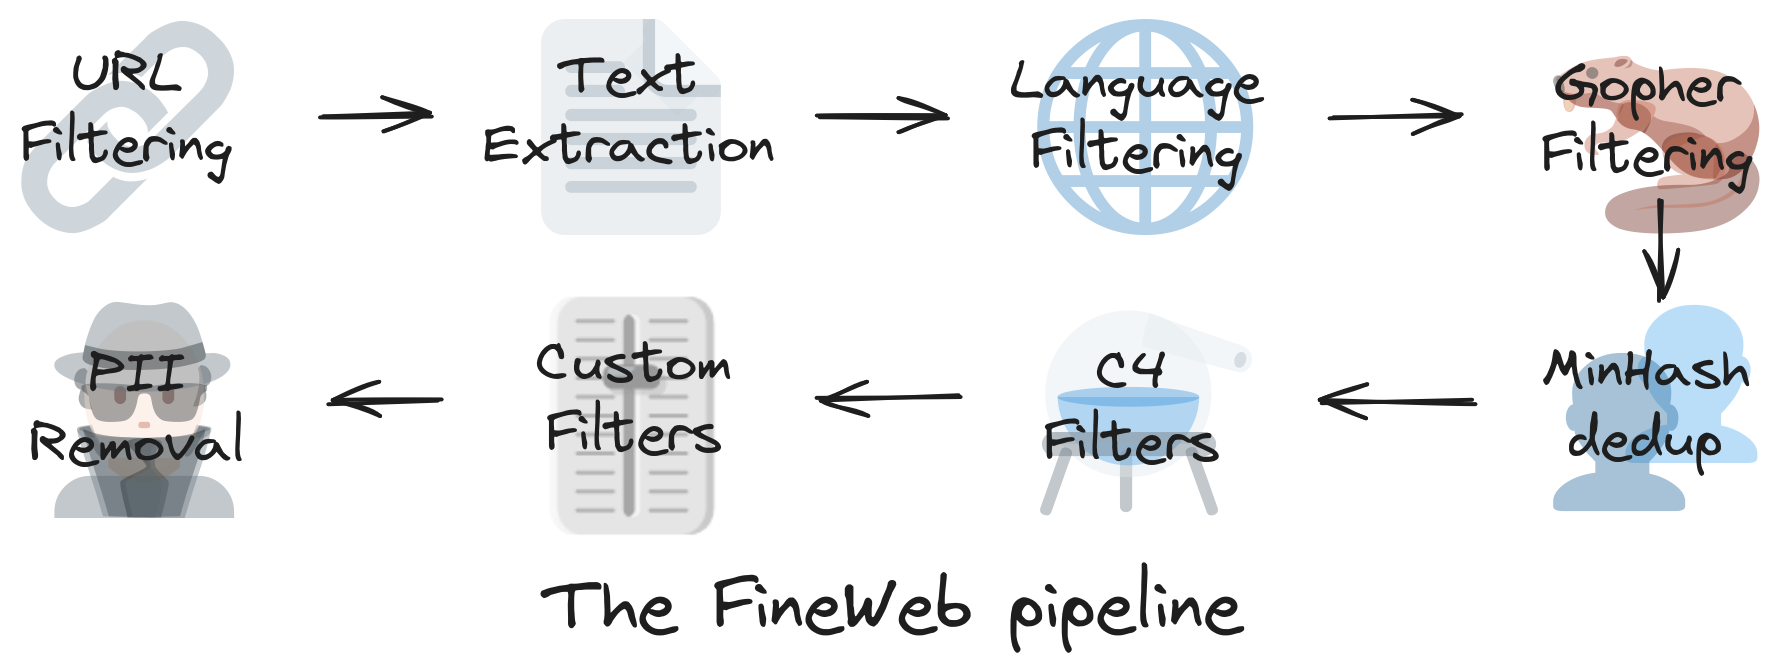

In [ ]:
import os
import numpy as np

path = "/content/drive/MyDrive/edu_fineweb10B"
files = sorted(os.listdir(path))

# Check total shards
print(f"Total shards: {len(files)}")

# Check a sample file
sample_file = os.path.join(path, files[0])  # First shard
tokens = np.load(sample_file)
print(f"Tokens in {files[0]}: {tokens.shape[0]}")


Total shards: 100
Tokens in edufineweb_train_000001.npy: 100000000


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
import math
import time
import inspect
from dataclasses import dataclass
import tiktoken
import numpy as np
from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

# Model Architecture: The Decoder-Only Transformer

The architecture of our model is based on the Transformer framework, as introduced by Vaswani et al. (2017) in Attention Is All You Need. The model follows a decoder-only structure, a design choice that aligns with the autoregressive nature of language modeling.

The Transformer architecture consists of multiple layers of self-attention and feed-forward neural networks. Each layer processes the input sequentially, leveraging positional encodings to maintain the order of tokens, as the transformer itself is inherently permutation-invariant.

In the decoder-only architecture, each token attends only to previous tokens within a given context window. This causal attention mechanism ensures that the model learns to predict the next token based solely on past information, adhering to the autoregressive objective.

The core components of the architecture include:

- **Input Embeddings and Positional Encoding**: Token embeddings are combined with positional encodings to provide the model with sequential order information.

- **Masked Multi-Head Self-Attention**: Attention heads compute attention scores while masking future tokens to preserve the autoregressive property.

- **Feed-Forward Layers**: Fully connected layers apply non-linear transformations to the attention outputs, enabling the model to capture complex language patterns.

- **Layer Normalization and Residual Connections**: These mechanisms facilitate stable training and mitigate vanishing gradient issues.

- **Output Projection and Softmax**: The final layer maps the hidden states into a vocabulary distribution, producing the next-token predictions.

This decoder-only design not only simplifies the architecture but also enhances performance in generative tasks. It enables the model to handle few-shot, one-shot, and zero-shot learning scenarios without task-specific modifications, as highlighted in the works Language Models are Few-Shot Learners and Language Models are Unsupervised Multitask Learners.

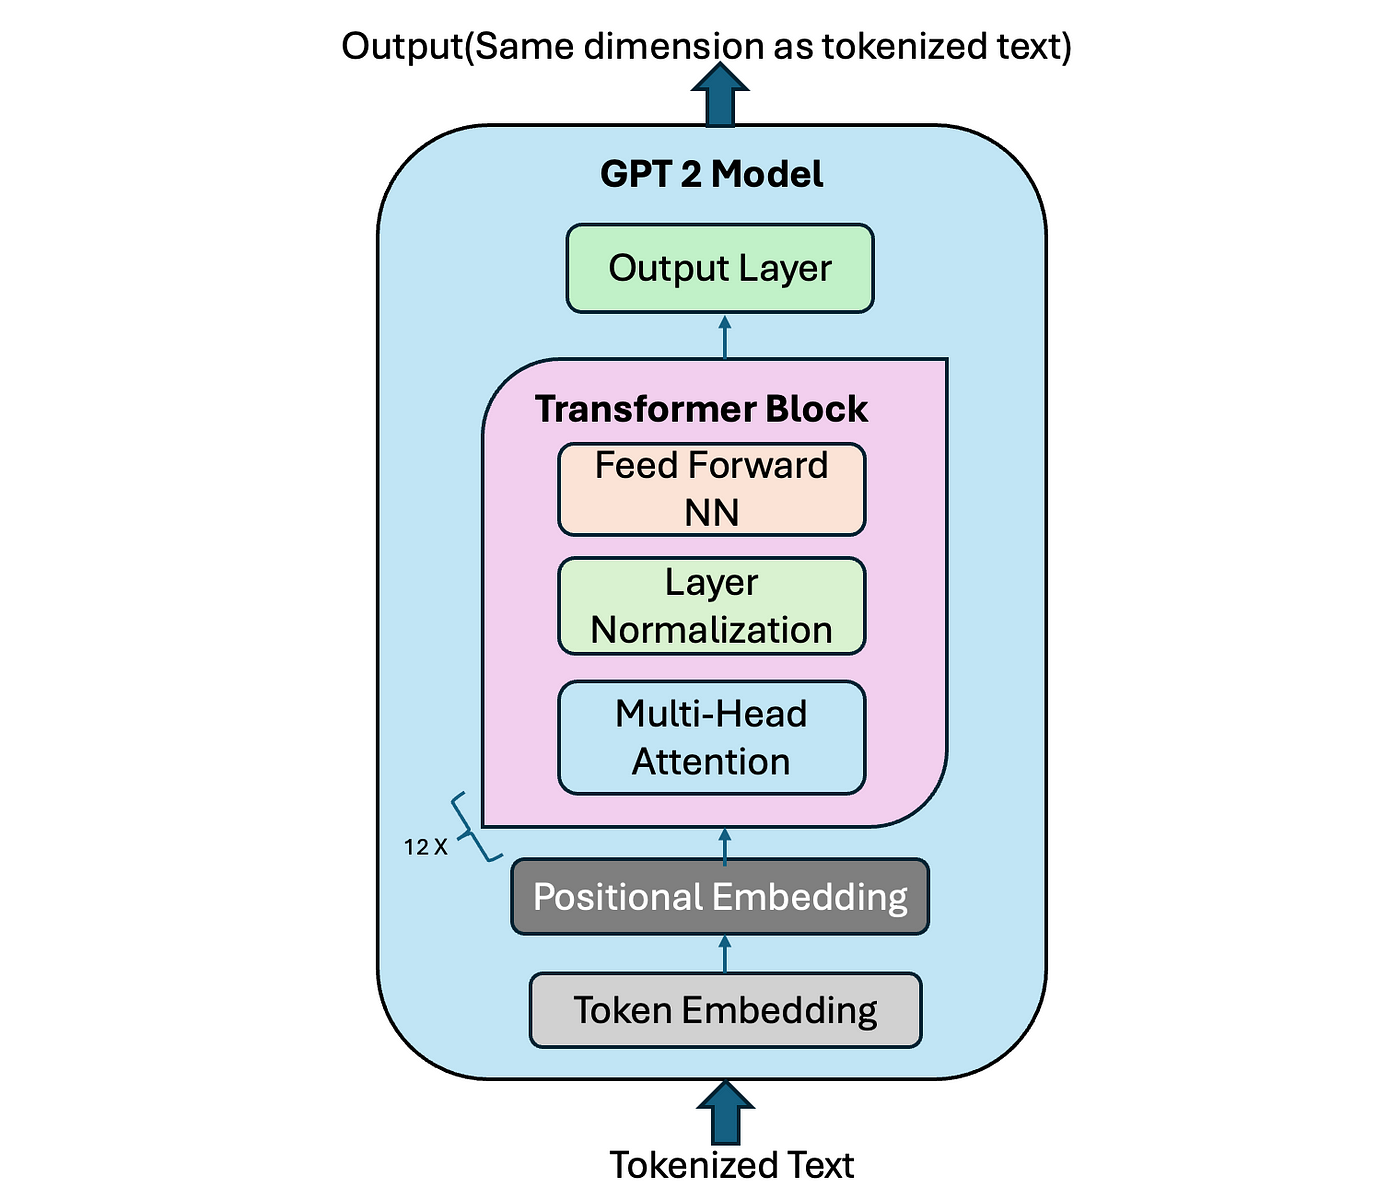

# Multi-Head Attention :

**"Attention is all you need paper"** : https://arxiv.org/pdf/1706.03762

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

`torch.nn.functional.scaled_dot_product_attention` automatically uses FlashAttention when available.
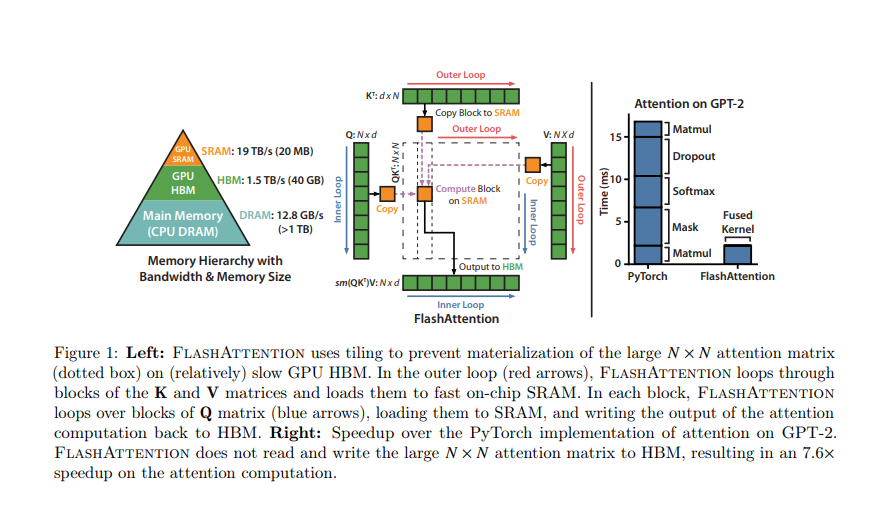

FlashAttention is a memory-efficient attention mechanism designed to optimize the computation of the attention matrix, particularly for large sequence lengths in transformer models like GPT-2. Traditional attention implementations often materialize the full
𝑁
×
𝑁
N×N attention matrix in GPU High Bandwidth Memory (HBM), which introduces significant memory overhead and slows down computations due to the frequent memory access. FlashAttention addresses this issue by strategically tiling the computation, utilizing faster on-chip memory (SRAM) to minimize HBM access and thereby enhance performance.

On the left side of the figure, the diagram illustrates how FlashAttention processes the attention matrix without storing the entire N×N matrix at once. Instead, it uses a two-level looping strategy. In the outer loop (represented by the red arrows), the algorithm iterates through blocks of the key (K) and value (V) matrices, loading these smaller blocks into the SRAM. This on-chip memory access is significantly faster than accessing HBM, reducing the memory bottleneck.

Within each block of the K and V matrices, FlashAttention employs an inner loop (indicated by the blue arrows) to process corresponding blocks of the query (Q) matrix. Each block of the Q matrix is loaded into SRAM, used to compute the attention scores for that block, and then the results are written back to HBM. This block-wise processing ensures that memory consumption remains constant, regardless of the sequence length, making FlashAttention highly scalable for long-context models.

The right side of the figure shows a performance comparison between FlashAttention and the standard PyTorch implementation of attention for GPT-2. The results highlight a substantial speedup, with FlashAttention achieving up to 7.6× faster attention computations. This performance gain is primarily attributed to the avoidance of repeated memory reads and writes of the large attention matrix to HBM, coupled with the efficient use of SRAM. By optimizing memory access patterns and minimizing data movement, FlashAttention significantly boosts the efficiency of transformer-based models, especially when handling long sequences.

**FlashAtention paper** : https://arxiv.org/pdf/2205.14135

## Feed-Forward layer :

The MLP class implements a feed-forward neural network component used within each transformer block. It consists of three layers: a fully connected layer
`(c_fc)`, followed by a GELU activation, and another fully connected layer
`(c_proj)`that projects back to the original embedding size.

The activation function used here is the Gaussian Error Linear Unit `(GELU)` with the approximate='tanh' argument. GELU is a smoother and more biologically plausible alternative to ReLU. It applies a non-linear transformation to the input by weighing it with the cumulative distribution function of a Gaussian distribution. This helps the model capture complex patterns and relationships more effectively.

The `nn.GELU(approximate='tanh')`is implemented as self.gelu in the MLP class, and it is applied immediately after the c_fc layer. The output is then passed through the c_proj layer to project it back to the original dimensionality of the embeddings.

**GAUSSIAN ERROR LINEAR UNITS (GELUS)** paper :https://arxiv.org/pdf/1606.08415

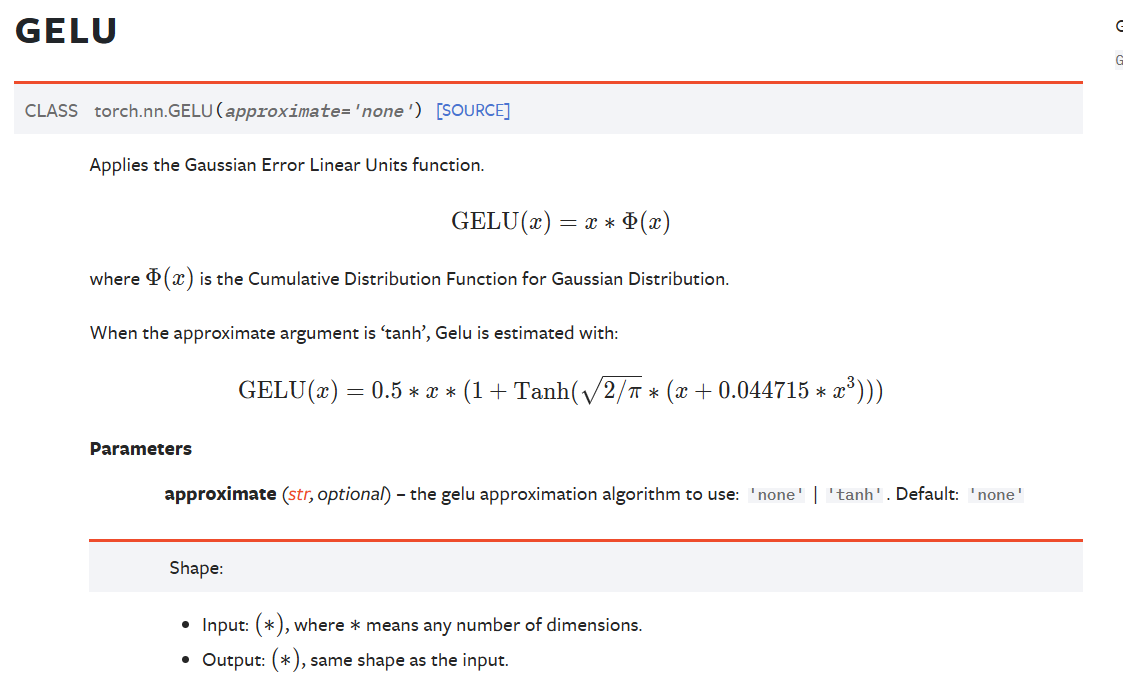

The line `self.c_proj.NANOGPT_SCALE_INIT = 1` is a custom attribute, used to indicate that this layer should apply the modified initialization scheme described in the paper. Specifically, it helps scale the weights of residual layers  where N is the number of residual layers. This scaling stabilizes training by preventing the residual connections from growing too large as the model depth increases."we will explain about that again"

In [ ]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

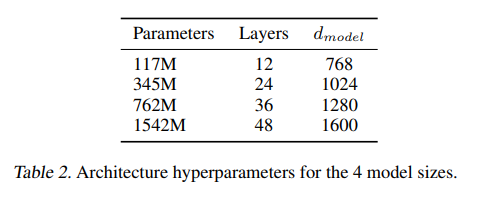

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


The GPT-2 architecture follows a decoder-only Transformer design, focusing solely on causal self-attention to generate text.

A key modification introduced in the architecture is the application of layer normalization (Ba et al., 2016) at the input of each sub-block, similar to pre-activation residual networks (He et al., 2016). Additionally, an extra layer normalization is applied after the final self-attention block, ensuring better training stability.

To account for the accumulation along the residual paths with increasing model depth, the initialization of weights in residual layers is scaled by 1/√N, where N represents the number of layers. Moreover, the vocabulary size is expanded to 50,257 tokens, the context size is increased from 512 to 1024 tokens, and a larger batch size of 512 is utilized.

These modifications are implemented in the code within the GPT2 class, specifically in the **__init__** method where **nn.LayerNorm** is used, and in the **_init_weights** method where the scaling factor is applied. The increased vocabulary size and context length are set in the **config** object passed during model initialization.

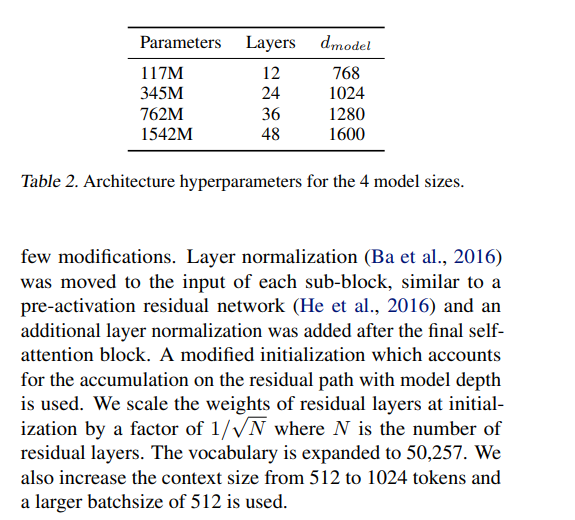

One of the fundamental design principles we employed is the weight-sharing scheme. We did use this scheme by directly tying the input word embeddings with the output language modeling head. This weight sharing not only reduces the overall memory footprint of the model but also ensures a consistent representation between input and output layers, promoting more stable and efficient learning during training.

As it is in the attention paper :

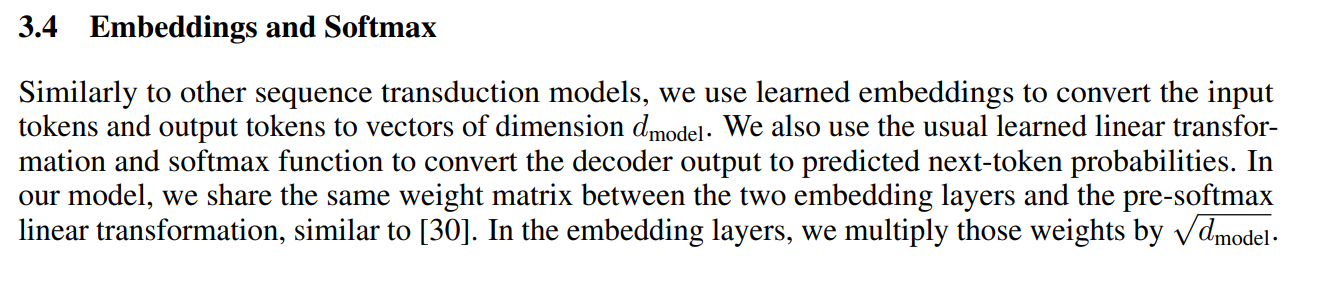

In our implementation, we used the AdamW optimizer to train the model efficiently while handling regularization with weight decay. The optimizer's configuration was carefully designed to balance learning performance and generalization capabilities. We set the learning rate as a crucial hyperparameter to control the step size during optimization, ensuring the model updates weights effectively without overshooting minima. The learning rate was paired with the beta values (0.9 and 0.95), which control the exponential moving averages of past gradients and squared gradients, respectively. The choice of these betas aligns with standard practices in training transformer models, where momentum helps stabilize learning.

The AdamW optimizer parameters also included epsilon, set to 1e-8, to prevent division by zero during numerical computations. This small constant is particularly useful when gradient magnitudes become extremely small, ensuring the stability of updates. Additionally, we leveraged the fused implementation of AdamW whenever available, especially when training on CUDA devices. Using the fused version can significantly improve training efficiency by optimizing low-level computations.

We adopted a weight decay strategy to improve generalization and mitigate overfitting. Specifically, we grouped parameters into two sets: those subject to weight decay and those exempt from it. Parameters with two or more dimensions, such as weights in matrix multiplications and embeddings, were decayed to discourage excessively large weight magnitudes. Conversely, biases and layer normalization parameters were excluded from weight decay to preserve their functionality, as these parameters do not benefit from the same regularization dynamics.

Throughout the training process, we consistently monitored the count of parameters in both groups to ensure the correctness of our optimizer configuration. This detailed setup not only aligns with best practices for training language models but also supports the model's stability and performance during optimization. By tuning these parameters effectively, we aimed to maximize learning efficiency while maintaining robust generalization to unseen data.

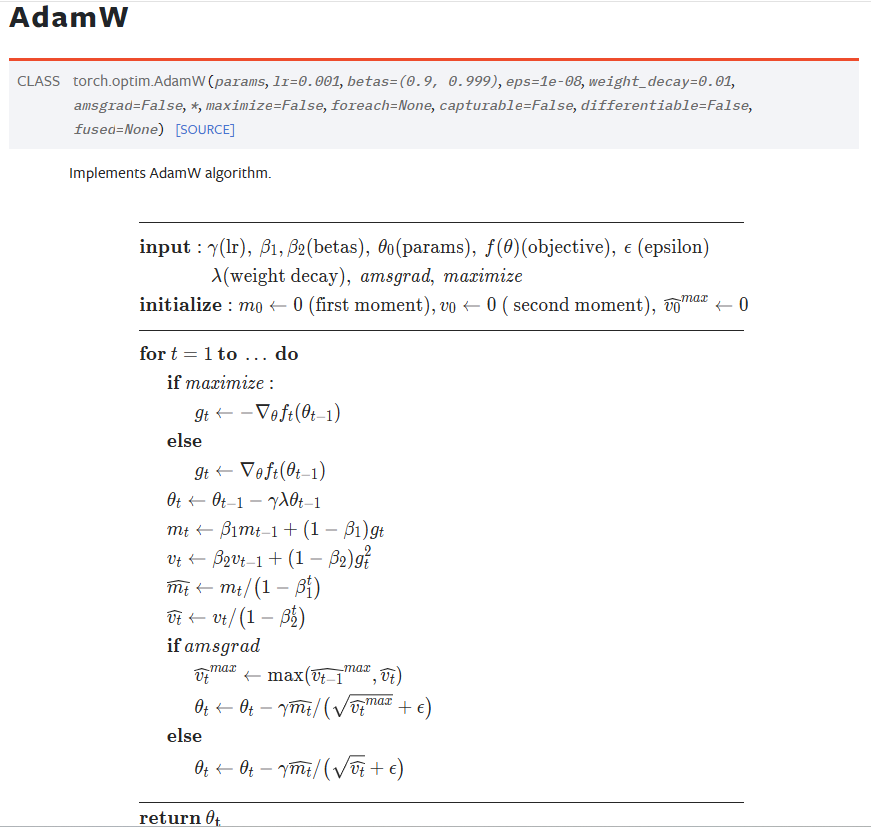

In [ ]:
class GPT2(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device_type ,master_process ):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if master_process:
            print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
            print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        if master_process:
            print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer


Through `from_pretrained` method, we facilitate the loading of pretrained weights from the Hugging Face GPT-2 models. The method ensures that tensor shapes and parameter names align with the expected architecture while correctly transposing weights originating from OpenAI's Conv1D layers. This alignment enables us to directly compare our model's performance with the original GPT-2 models, providing a practical benchmark to assess improvements or deviations.

# Efficient Data Loading for Large Datasets with DataLoaderLite

The `load_tokens` function is responsible for loading tokenized data from a given file. It uses NumPy to read the file contents and converts the array to 32-bit integers for compatibility. The data is then transformed into a PyTorch tensor with a long integer type, which is essential for many NLP models.

The `DataLoaderLite` class provides a streamlined mechanism for loading batches of tokenized data, ensuring compatibility with distributed training setups. It is initialized with several parameters:

- B (Batch size): Determines how many sequences are processed simultaneously.

- T (Sequence length): Defines the length of each sequence.

- process_rank: Identifies the process ID in a multi-process environment.

- num_processes: The total number of processes participating in the training.

- split: Indicates whether the data is for training or validation.

- master_process: Flags whether the current process is the master.

During initialization, the class locates the relevant data shards for the specified split and prepares for data loading.


The dataset is stored in multiple shards located in a predefined directory. The class collects these shards, sorts them, and initializes the data by loading the first shard. Each shard contains sequences that are tokenized and ready for model training.


The reset method reinitializes the loader to start from the first shard and position. This is useful when reusing the loader or restarting training.


The next_batch method handles the core data loading logic. It retrieves a chunk of tokens, splits them into inputs (x) and targets (y), and then advances the current position. If the end of the current shard is reached, the loader automatically moves to the next shard.


In [ ]:
def load_tokens(filename):
    npt = np.load(filename)
    npt = npt.astype(np.int32) # added after video
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes, split,master_process):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root = "/content/drive/MyDrive/edu_fineweb10B"
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split {split}"
        if master_process:
            print(f"found {len(shards)} shards for split {split}")
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = B * T * self.process_rank
        return x, y

We will use the  get_most_likely_row function later for evaluation , it evaluates the likelihood of different token sequences and identifies the most likely one based on a masked loss calculation. It takes three parameters: tokens, mask, and logits.

First, the function shifts the logits by one position to match the target tokens for next-token prediction. It extracts the predicted logits except for the last position and the corresponding tokens except for the first position. These tensors are then flattened for efficient loss calculation.

Next, the function uses the cross-entropy loss to evaluate the prediction performance. It calculates the loss independently for each position without averaging, resulting in a loss value for each token.

After that, the mask is shifted similarly to the tokens to align with the completion region. The function applies this mask to the loss values, ensuring only the completion tokens contribute to the evaluation. The sum of the masked losses is divided by the number of masked positions to compute the average loss for each row.

Finally, the function selects the row with the minimum average loss, indicating the sequence with the highest likelihood according to the model's predictions. The index of this row is returned as the final result.

In [ ]:
def get_most_likely_row(tokens, mask, logits): # A function to use later in evaluation
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

I used Distributed Data Parallel (DDP)  when multiple A100 GPUs are available through SSH connections in the `src` folder. This setup allows for efficient parallel processing across multiple devices. However, when working within a Jupyter notebook environment, only a single A100 GPU can be accessed. Despite this limitation, we kept the DDP implementation intact to maintain consistency.

DDP relies on CUDA for GPU communication, and during initialization, it sets the appropriate device for each process based on environment variables. The nccl backend is used to handle inter-GPU communication, ensuring efficient training. If CUDA is not available, the code defaults to running on the CPU or, if supported, on Apple's Metal Performance Shaders (MPS). Additionally, the manual seed for reproducibility is set for both CPU and CUDA devices.




In [ ]:
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), "for now i think we need CUDA for DDP"
    init_process_group(backend='nccl')
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
else:
    # vanilla, non-DDP run
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True
    # attempt to autodetect device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = "mps"
    print(f"using device: {device}")

device_type = "cuda" if device.startswith("cuda") else "cpu"

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

using device: cuda



The encoding process uses the GPT-2 tokenizer, and the batch size is carefully calculated to align with the specified gradient accumulation steps. Two separate data loaders are created, one for the training set and another for the validation set. Both data loaders distribute the workload according to the rank of each process in the DDP configuration. This design ensures scalability when more GPUs become available while maintaining compatibility within the single-GPU constraints of the Jupyter notebook environment.

Using 2**18 (262,144) as the batch size and all the rest of config numbers is a deliberate and efficient choice due to the nature of binary-based computations in modern hardware.

Why Powers of Two Matter:
- Memory Alignment:
Modern GPUs and TPUs are optimized to handle data sizes that align with powers of two. Using 2**18 ensures efficient memory allocation and minimizes overhead caused by irregular batch sizes.

- Vectorized Operations:
Many deep learning operations are vectorized and rely on matrix multiplication. Powers-of-two batch sizes align naturally with these operations, reducing computational overhead and speeding up processing.

- Cache Efficiency:
Hardware caches are typically structured around binary boundaries. A batch size like 2**18 fits neatly into cache lines, reducing cache misses and improving throughput.

- Parallelism:
Distributed training systems often shard data across devices. With a power-of-two batch size, data partitioning is more straightforward and evenly distributed across multiple GPUs.

Choosing 2**18 isn't just about the large number—it's about leveraging the binary-friendly architecture of modern hardware to maximize efficiency and performance.

In [ ]:
enc = tiktoken.get_encoding("gpt2")

total_batch_size = 262144 # 2**18
B = 32 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0, "make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps = total_batch_size // (B * T * ddp_world_size)
if master_process:
    print(f"total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="train" , master_process=master_process)
val_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="val",master_process=master_process)

torch.set_float32_matmul_precision('high')

total desired batch size: 262144
=> calculated gradient accumulation steps: 8
found 99 shards for split train
found 1 shards for split val


torch.set_float32_matmul_precision('high') is for performance too :
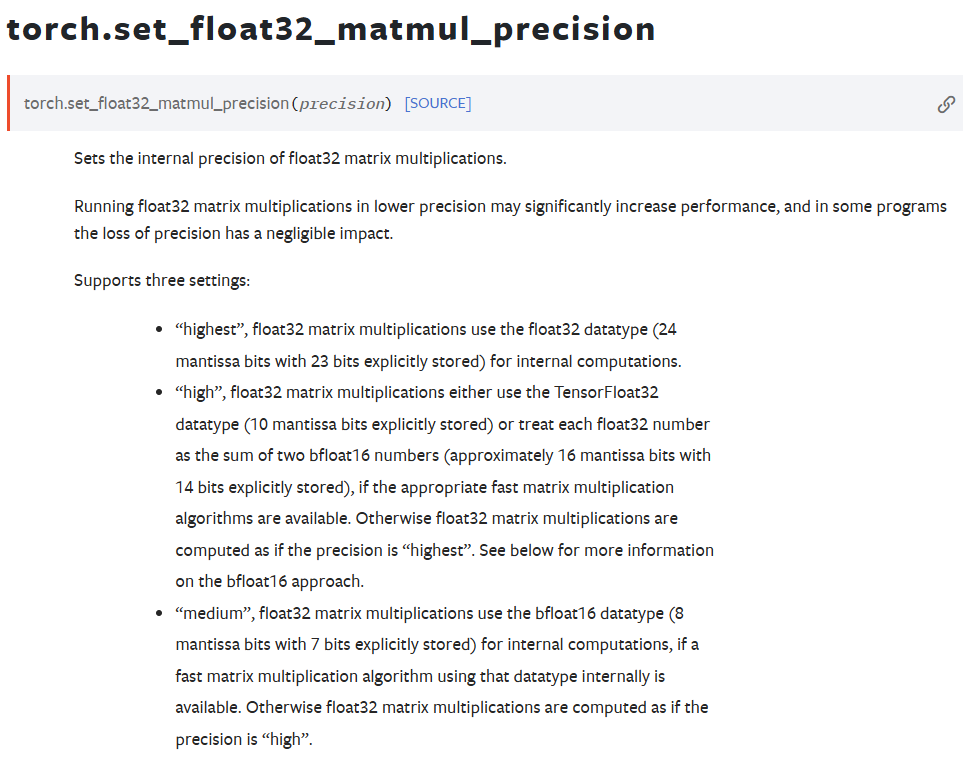

# HellaSwag: Can a Machine Really Finish Your Sentence?

Hellaswag paper : https://arxiv.org/pdf/1905.07830

We want to evaluate the Open AI GPT-2 (124M) model to assess performance on the HellaSwag dataset To compare it later with our custom model. HellaSwag is a benchmark for commonsense reasoning, and the validation set contains 10,042 examples. The results show an accuracy of approximately 29.56% in completion-style evaluation.

To access the dataset, we download the necessary files from the official HellaSwag repository and store them in a local directory. We then render each example into token sequences, where each candidate ending is paired with the context. This process involves encoding the context and its possible completions into token tensors while also generating corresponding mask tensors to identify the completion regions for evaluation.

When processing the examples, we compute the loss for each candidate ending based on the language model's predictions. We apply a mask to focus solely on the completion region, calculate the average loss for each ending, and select the ending with the lowest loss as the model's prediction. The correctness of the predictions is tracked to calculate both standard accuracy and normalized accuracy.

Throughout the evaluation, we adopt efficient practices like setting the precision to 'high' for matrix multiplications to leverage TensorFloat-32 operations where possible. Although the original code was designed to support distributed data parallel (DDP) execution across multiple A100 GPUs, we retain the DDP structure even when running on a single A100 GPU through a Jupyter notebook. This approach ensures consistency with the original implementation while adapting to the notebook environment's constraints.

The evaluation loop iterates through the validation set, printing intermediate results for a few initial examples. This provides us with insights into the model's performance on various contexts and endings. Ultimately, we aim to understand the Open AI GPT-2 model's capability in commonsense reasoning tasks by observing its performance on the HellaSwag dataset.



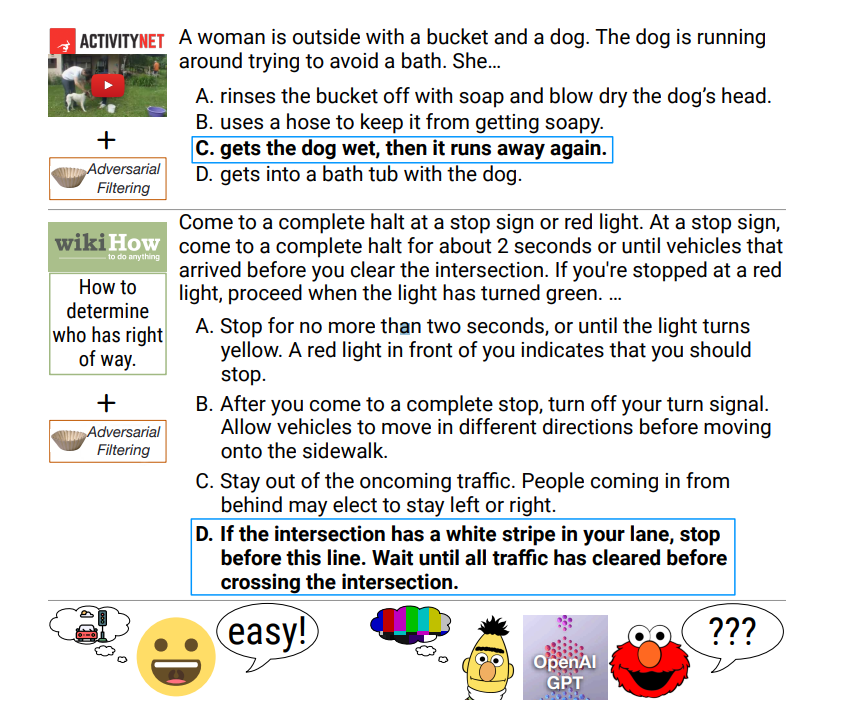

In [ ]:
"""
gpt2 (124M)
- eleuther harness reports acc 28.92%, acc_norm 31.14% (multiple choice style)
- this script: 10042 acc: 0.2968/10042=0.2956 acc_norm: 0.2955 (completion style)


The validation set of HellaSwag has a total of 10,042 examples.
"""

import os
import json
import requests
import tiktoken
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel

In [ ]:
DATA_CACHE_DIR = os.path.join(os.getcwd(), "hellaswag")

def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

hellaswags = {
    "train": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_train.jsonl",
    "val": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_val.jsonl",
    "test": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_test.jsonl",
}

enc = tiktoken.get_encoding("gpt2")

In [ ]:
def download(split):
    """Downloads HellaSwag DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)
    data_url = hellaswags[split]
    data_filename = os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)

In [ ]:
def render_example(example):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = enc.encode(ctx)
    data["ctx_tokens"] = ctx_tokens
    tok_rows = []
    mask_rows = []
    for end in endings:
        end_tokens = enc.encode(" " + end) # note: prepending " " because GPT-2 tokenizer
        tok_rows.append(ctx_tokens + end_tokens)
        mask_rows.append([0]*len(ctx_tokens) + [1]*len(end_tokens))
        data["ending_tokens"].append(end_tokens)

    # have to be careful during the collation because the number of tokens in each row can differ
    max_len = max(len(row) for row in tok_rows)
    tokens = torch.zeros((4, max_len), dtype=torch.long)
    mask = torch.zeros((4, max_len), dtype=torch.long)
    for i, (tok_row, mask_row) in enumerate(zip(tok_rows, mask_rows)):
        tokens[i, :len(tok_row)] = torch.tensor(tok_row)
        mask[i, :len(mask_row)] = torch.tensor(mask_row)

    return data, tokens, mask, label

In [ ]:
def iterate_examples(split):
    # there are 10,042 examples in total in val
    download(split)
    with open(os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl"), "r") as f:
        for line in f:
            example = json.loads(line)
            yield example

In [ ]:
@torch.no_grad()
def evaluate(model_type, device):

    torch.set_float32_matmul_precision('high') # use tf32
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.to(device)
    # model = torch.compile(model) # optionally torch compile the model

    num_correct_norm = 0
    num_correct = 0
    num_total = 0
    for example in iterate_examples("val"):
        data, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)

        # get the logits
        logits = model(tokens).logits
        # evaluate the autoregressive loss at all positions
        shift_logits = (logits[..., :-1, :]).contiguous()
        shift_tokens = (tokens[..., 1:]).contiguous()
        flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
        flat_shift_tokens = shift_tokens.view(-1)
        shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
        shift_losses = shift_losses.view(tokens.size(0), -1)
        # now get the average loss just for the completion region (where mask == 1), in each row
        shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
        masked_shift_losses = shift_losses * shift_mask
        # sum and divide by the number of 1s in the mask
        sum_loss = masked_shift_losses.sum(dim=1)
        avg_loss = sum_loss / shift_mask.sum(dim=1)
        # now we have a loss for each of the 4 completions
        # the one with the lowest loss should be the most likely
        pred = sum_loss.argmin().item()
        pred_norm = avg_loss.argmin().item()

        # accumulate stats
        num_total += 1
        num_correct += int(pred == label)
        num_correct_norm += int(pred_norm == label)
        print(f"{num_total} acc_norm: {num_correct_norm}/{num_total}={num_correct_norm/num_total:.4f}")

        # debug: pretty print a few examples, and the losses in each case
        if num_total < 10:
            print("---")
            print(f"Context:\n {example['ctx']}")
            print(f"Endings:")
            for i, end in enumerate(example["endings"]):
                print(f"{i} (loss: {avg_loss[i].item():.4f}) {end}")
            print(f"predicted: {pred_norm}, actual: {label}")

evaluate(model_type="gpt2", device="cuda")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/content/hellaswag/hellaswag_val.jsonl: 11.7MiB [00:00, 71.2MiB/s]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
5043 acc_norm: 1602/5043=0.3177
5044 acc_norm: 1602/5044=0.3176
5045 acc_norm: 1602/5045=0.3175
5046 acc_norm: 1602/5046=0.3175
5047 acc_norm: 1603/5047=0.3176
5048 acc_norm: 1604/5048=0.3177
5049 acc_norm: 1604/5049=0.3177
5050 acc_norm: 1604/5050=0.3176
5051 acc_norm: 1604/5051=0.3176
5052 acc_norm: 1604/5052=0.3175
5053 acc_norm: 1605/5053=0.3176
5054 acc_norm: 1605/5054=0.3176
5055 acc_norm: 1606/5055=0.3177
5056 acc_norm: 1606/5056=0.3176
5057 acc_norm: 1606/5057=0.3176
5058 acc_norm: 1606/5058=0.3175
5059 acc_norm: 1606/5059=0.3175
5060 acc_norm: 1607/5060=0.3176
5061 acc_norm: 1607/5061=0.3175
5062 acc_norm: 1607/5062=0.3175
5063 acc_norm: 1607/5063=0.3174
5064 acc_norm: 1607/5064=0.3173
5065 acc_norm: 1607/5065=0.3173
5066 acc_norm: 1607/5066=0.3172
5067 acc_norm: 1608/5067=0.3173
5068 acc_norm: 1608/5068=0.3173
5069 acc_norm: 1608/5069=0.3172
5070 acc_norm: 1608/5070=0.3172
5071 acc_norm: 1608/5071=0

# Model training :

In this section, we describe the model training process for our GPT-2 implementation. We used the `GPT2` class with a configuration defined by `GPTConfig`, specifying a vocabulary size of 50,304 tokens. This ensures compatibility with standard GPT-2 tokenization while allowing efficient processing of text data.

We initialized the model using `model = GPT2(GPTConfig(vocab_size=50304))`.

The model was then moved to the designated device using `model.to(device)`, which typically refers to a GPU for faster training.

To optimize performance, we considered the use of `torch.compile` with the `use_compile` flag. When set to `True`, `torch.compile` can accelerate PyTorch operations, but we observed that it interfered with the HellaSwag evaluation and generation processes, so we disabled it for this task.

In distributed training scenarios, we utilized `DistributedDataParallel` (DDP) to distribute the model across multiple GPUs. The `ddp_local_rank` was specified to ensure that each process operated on the correct GPU. After wrapping the model in DDP, we extracted the raw, unwrapped model using the line `raw_model = model.module if ddp else model`. This provided us with direct access to the underlying model parameters when needed.




look to : https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html , https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html

We used some of the gpt-3 training details :
- Adam optimizer params "we used AdamW as we talked earlier.
- Gradient global norm clipping .
- Cosine decay of learning rate.
- Learning rate warmup
- Data are sampled without replacement as we implemented in the dataloader class "like step by step we iterate through the whole dataset
- Weights decay of 0.1 as we did in the optimier config

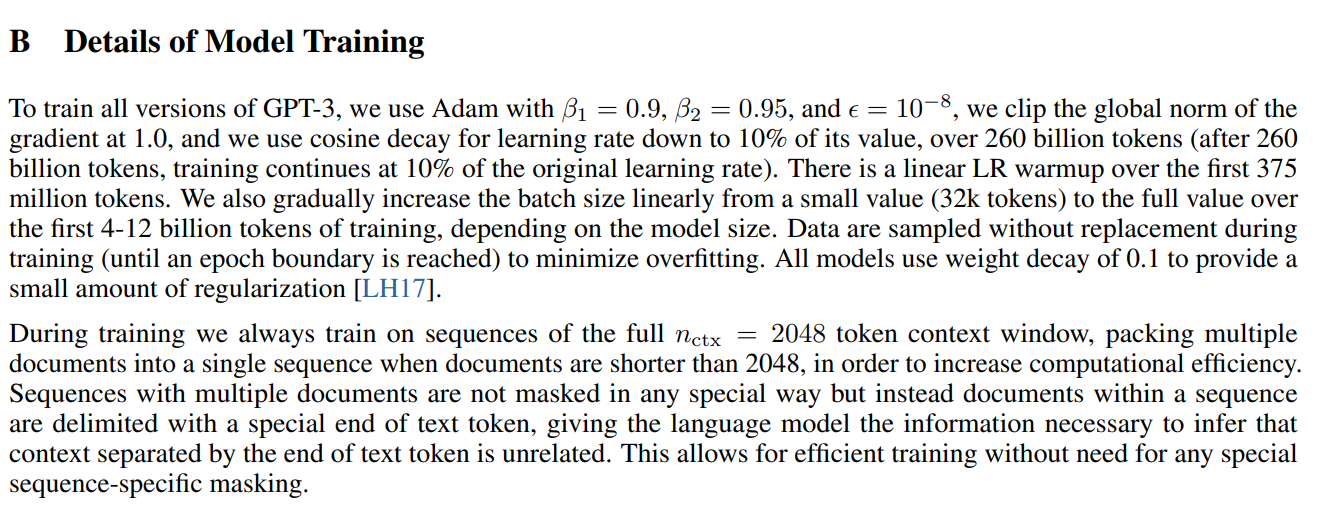

In [ ]:
model = GPT2(GPTConfig(vocab_size=50304))
# model = GPT.from_pretrained("gpt2") # or init from OpenAI GPT-2
model.to(device)
use_compile = False # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model)
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])
raw_model = model.module if ddp else model # always contains the "raw" unwrapped model

We adopted a learning rate schedule with both warm-up and decay phases. The maximum learning rate was set to `6e-4`, and the minimum learning rate to `6e-5`. The schedule was implemented via the `get_lr` function, which employed the following strategy:

1. **Warm-up Phase:** For the first 715 steps, we used a linear increase from 0 to the maximum learning rate. This gradual increase helped the model stabilize its learning dynamics early in training.
2. **Decay Phase:** After the warm-up, we applied cosine decay, reducing the learning rate from its peak value down to the minimum learning rate over the remaining training steps.
3. **Final Phase:** Beyond 38,146 steps, the learning rate was fixed at the minimum value to maintain training stability.

To implement these phases, we computed the learning rate dynamically using the formula:

- For warm-up: `max_lr * (it + 1) / warmup_steps`
- For decay: `min_lr + 0.5 * (1 + cos(pi * decay_ratio)) * (max_lr - min_lr)`

Finally, we initialized the optimizer through the `configure_optimizers` method, which set the weight decay to 0.1 and the learning rate to `6e-4`. We specified the device type to ensure efficient parameter updates and passed the `master_process` argument to coordinate optimization steps across processes.

Through this approach, we successfully configured a flexible and efficient training pipeline, leveraging advanced techniques like DDP and cosine learning rate decay to maximize performance and model generalization capabilities.

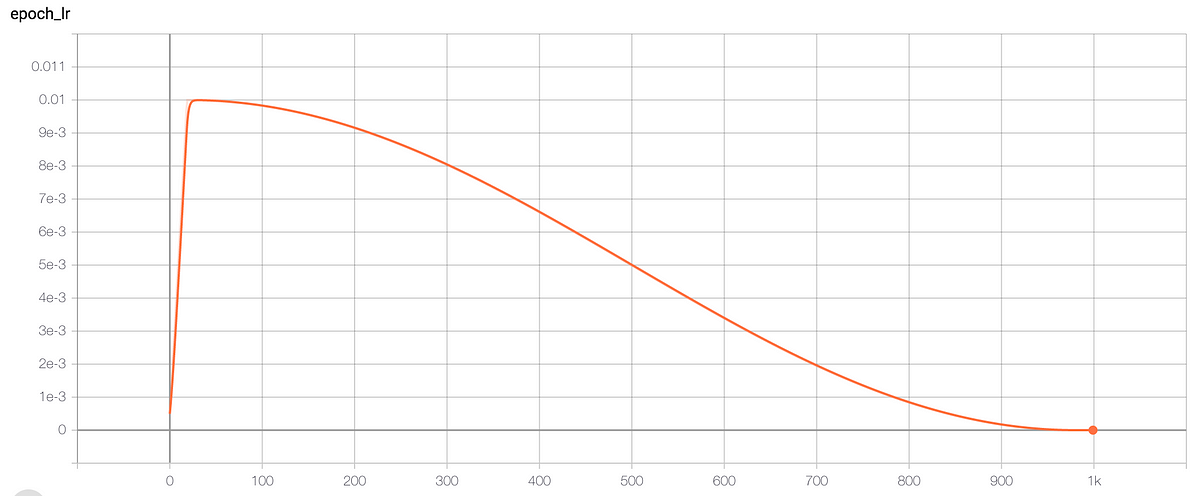

In [ ]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 715
max_steps = 38146 # to get ~1 epoch, if data is 10B tokens and batch size 0.25M tokens
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [ ]:
# optimize!
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device_type , master_process= master_process)

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


We start by setting up a logging directory named log and creating an empty log file called log.txt. This will help us track the training process, including training loss, validation performance, and model generations. If the directory already exists, we avoid errors by using the exist_ok=True argument.

Our training loop runs for a defined number of steps (max_steps). At each step, we first measure the time taken for performance monitoring. We periodically evaluate the model's performance on the validation set every 250 steps or on the final step. During validation, we switch the model to evaluation mode with model.eval() and process a subset of validation batches without updating the model parameters, thanks to torch.no_grad(). The validation loss is averaged over 20 batches and logged for later analysis. If we're using distributed training, we synchronize results across processes to get a global view of the model's performance.

Every 250 steps, we also evaluate the model's accuracy on the HellaSwag dataset, a benchmark for commonsense reasoning. We carefully distribute the evaluation workload across different processes in distributed settings and then synchronize the results to get the total number of correct predictions. This helps us track how well the model generalizes to this specific benchmark task.

To provide more insight into the model's capabilities, we generate sample completions at regular intervals. We use top-k sampling to introduce diversity, selecting the next token from the 50 most likely options. By printing these sample texts, we get a qualitative sense of how the model is learning to generate coherent text.

The core of the training process happens when we switch the model back to training mode with model.train(). For each training step, we accumulate gradients over multiple micro-steps to simulate larger batch sizes without exceeding memory limits. We scale the loss accordingly to maintain consistent gradient magnitudes. We also clip gradients to avoid exploding gradients, which can destabilize training. After the backward pass, we adjust the learning rate dynamically with get_lr() and update the optimizer's parameters.

Throughout the process, we track key performance metrics like training loss, learning rate, gradient norms, processing time, and tokens processed per second. These details are printed to the console and appended to our log file. Once training is complete, we clean up distributed resources if necessary

for torch autocast : look to  : https://pytorch.org/docs/stable/amp.html#autocasting ,

In [ ]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: # open for writing to clear the file
    pass

for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation loss
    if step % 250 == 0 or last_step:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        if ddp:
            dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
        if master_process:
            print(f"validation loss: {val_loss_accum.item():.4f}")
            with open(log_file, "a") as f:
                f.write(f"{step} val {val_loss_accum.item():.4f}\n")
            if step > 0 and (step % 5000 == 0 or last_step):
                # optionally write model checkpoints
                checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'val_loss': val_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)

    # once in a while evaluate hellaswag
    if (step % 250 == 0 or last_step) and (not use_compile):
        num_correct_norm = 0
        num_total = 0
        for i, example in enumerate(iterate_examples("val")):
            # only process examples where i % ddp_world_size == ddp_rank
            if i % ddp_world_size != ddp_rank:
                continue
            # render the example into tokens and labels
            _, tokens, mask, label = render_example(example)
            tokens = tokens.to(device)
            mask = mask.to(device)
            # get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(tokens)
                pred_norm = get_most_likely_row(tokens, mask, logits)
            num_total += 1
            num_correct_norm += int(pred_norm == label)
        # reduce the stats across all processes
        if ddp:
            num_total = torch.tensor(num_total, dtype=torch.long, device=device)
            num_correct_norm = torch.tensor(num_correct_norm, dtype=torch.long, device=device)
            dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
            dist.all_reduce(num_correct_norm, op=dist.ReduceOp.SUM)
            num_total = num_total.item()
            num_correct_norm = num_correct_norm.item()
        acc_norm = num_correct_norm / num_total
        if master_process:
            print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")
            with open(log_file, "a") as f:
                f.write(f"{step} hella {acc_norm:.4f}\n")

    # once in a while generate from the model (except step 0, which is noise)
    if ((step > 0 and step % 250 == 0) or last_step) and (not use_compile):
        model.eval()
        num_return_sequences = 4
        max_length = 32
        tokens = enc.encode("Hello, I'm a language model,")
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42 + ddp_rank)
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(xgen) # (B, T, vocab_size)
                # take the logits at the last position
                logits = logits[:, -1, :] # (B, vocab_size)
                # get the probabilities
                probs = F.softmax(logits, dim=-1)
                # do top-k sampling of 50 (huggingface pipeline default)
                # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                # gather the corresponding indices
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
                xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f"rank {ddp_rank} sample {i}: {decoded}")

    # do one step of the optimization
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        if ddp:
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # we have to scale the loss to account for gradient accumulation,
        # because the gradients just add on each successive backward().
        # addition of gradients corresponds to a SUM in the objective, but
        # instead of a SUM we want MEAN. Scale the loss here so it comes out right
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    if ddp:
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    if device_type == "cuda":
        torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
    tokens_per_sec = tokens_processed / dt
    if master_process:
        print(f"step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
        with open(log_file, "a") as f:
            f.write(f"{step} train {loss_accum.item():.6f}\n")

if ddp:
    destroy_process_group()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
step 33291 | loss: 3.090064 | lr 8.2107e-05 | norm: 0.4923 | dt: 1729.08ms | tok/sec: 151609.31
step 33292 | loss: 3.093540 | lr 8.2098e-05 | norm: 0.4509 | dt: 1727.73ms | tok/sec: 151727.62
step 33293 | loss: 3.098835 | lr 8.2089e-05 | norm: 0.4508 | dt: 1729.75ms | tok/sec: 151550.11
step 33294 | loss: 3.057432 | lr 8.2080e-05 | norm: 0.4569 | dt: 1730.88ms | tok/sec: 151450.87
step 33295 | loss: 3.028081 | lr 8.2071e-05 | norm: 0.4451 | dt: 1728.51ms | tok/sec: 151658.51
step 33296 | loss: 3.172955 | lr 8.2062e-05 | norm: 0.5228 | dt: 1729.41ms | tok/sec: 151580.00
step 33297 | loss: 3.128413 | lr 8.2053e-05 | norm: 0.4354 | dt: 1728.92ms | tok/sec: 151623.40
step 33298 | loss: 3.176381 | lr 8.2044e-05 | norm: 0.4603 | dt: 1729.33ms | tok/sec: 151587.07
step 33299 | loss: 3.029223 | lr 8.2035e-05 | norm: 0.4841 | dt: 1729.07ms | tok/sec: 151609.77
step 33300 | loss: 3.036005 | lr 8.2026e-05 | norm: 0.4525

In [ ]:
checkpoint_path = os.path.join(log_dir, f"final_gpt2_124m.pt")
checkpoint = {
    'model': raw_model.state_dict(),
    'config': raw_model.config,
    'step': step,
    'val_loss': val_loss_accum.item(),
    'optimizer': optimizer.state_dict()
}
torch.save(checkpoint, checkpoint_path)

# samples generation:

In [ ]:
def generate(model, prompt, max_tokens=200, num_samples=1, temperature=1.0, top_k=50, device='cuda'):
    # Ensure model is in eval mode
    model.eval()

    # Encode the prompt
    tokens = enc.encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_samples, 1)
    x = tokens.to(device)

    # Set up random generator for reproducibility
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(42)

    with torch.no_grad():
        while x.size(1) < len(tokens) + max_tokens:
            # Forward pass with your mixed precision setting
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, _ = model(x)

            # Get logits of the last token
            logits = logits[:, -1, :] / temperature

            # Apply top-k sampling
            probs = F.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, top_k, dim=-1)

            # Sample from the top-k distribution
            idx_next = torch.gather(
                topk_indices,
                -1,
                torch.multinomial(topk_probs, 1, generator=sample_rng)
            )

            # Append to the sequence
            x = torch.cat((x, idx_next), dim=1)

    # Decode the generated sequences
    generated_texts = []
    for i in range(num_samples):
        tokens = x[i].tolist()
        text = enc.decode(tokens)
        generated_texts.append(text)

    return generated_texts

# Usage example:
prompt = "Hello, I'm a language model,"
outputs = generate(
    model,
    prompt=prompt,
    max_tokens=200,
    num_samples=1,  # Generate one sample
    temperature=0.8  # Lower = more focused, higher = more creative
)

for i, text in enumerate(outputs):
    print(f"Sample {i+1}:\n{text}\n")

Sample 1:
Hello, I'm a language model, and I use a language model, the language model, to model something. It's just a very general model, it's just a language model, and that's what I'm about to do, right, but I'm a language model, so I'm going to do a language model, to model everything. I'm going to do a language model, and now the language model, let's talk about that. And so, I'm going to look at that, if you're working in these, say, in-place situations, you'll see that right, right, here is a situation where you're working in a virtual world that's in a virtual world, and you're working in this virtual world. And you know, you're working in this virtual world. And you're working in virtual worlds, right? So, I was working in another virtual world, and I'm working in another virtual world. And the virtual world in this virtual



In [ ]:
prompt = "artificial intelligence"
outputs = generate(
    model,
    prompt=prompt,
    max_tokens=200,
    num_samples=1,  # Generate one sample
    temperature=0.8  # Lower = more focused, higher = more creative
)

for i, text in enumerate(outputs):
    print(f"Sample {i+1}:\n{text}\n")

Sample 1:
artificial intelligence (AI) is the field of artificial intelligence that seeks to improve the design of machines that perform tasks. These machines use data to create algorithms and make decisions that are accurate and efficient. These algorithms can be designed to perform specific tasks automatically or with minimal human intervention.
The field of artificial intelligence focuses on designing machines that can perform tasks that would not be possible with computers. These machines can be used in a variety of different fields, including the design of devices that are used in a wide variety of industries, as well as the design of products that are used in public spaces, schools, factories, and other places.
An example of an Artificial Intelligence-based product is a robotic arm that can perform repetitive tasks such as opening and closing doors, opening and closing doors, and doing other tasks such as turning a key, opening a window, and cleaning a cabinet. These intelligent 

In [ ]:
prompt = "Time is money"
outputs = generate(
    model,
    prompt=prompt,
    max_tokens=200,
    num_samples=1,  # Generate one sample
    temperature=0.8  # Lower = more focused, higher = more creative
)

for i, text in enumerate(outputs):
    print(f"Sample {i+1}:\n{text}\n")

Sample 1:
Time is money, and a lot more. And what happened to the cash flow problem? What happened to the savings problem?
We are not talking about money, but, for many people, money is a kind of life skill. And that comes to the forefront when we talk about money.
Let’s talk about money.
Money is what we put into our mouths.
Money is in the air.
Money is the currency.
Money is like a kind of glue.
Money is good for the environment.
Money is the money we put into our mouths.
Money is the currency we put into our mouths.
Money is the currency we put into our mouths.
Money is the currency we put into our mouths.
Money is the money we put into our mouths.
Money is the money we put into our mouths.
Money is the money we put into our mouths.
Money is the money we put into our mouths.
Money is the money



# Performance Comparison: Our Custom GPT-2 Model vs. Baseline Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

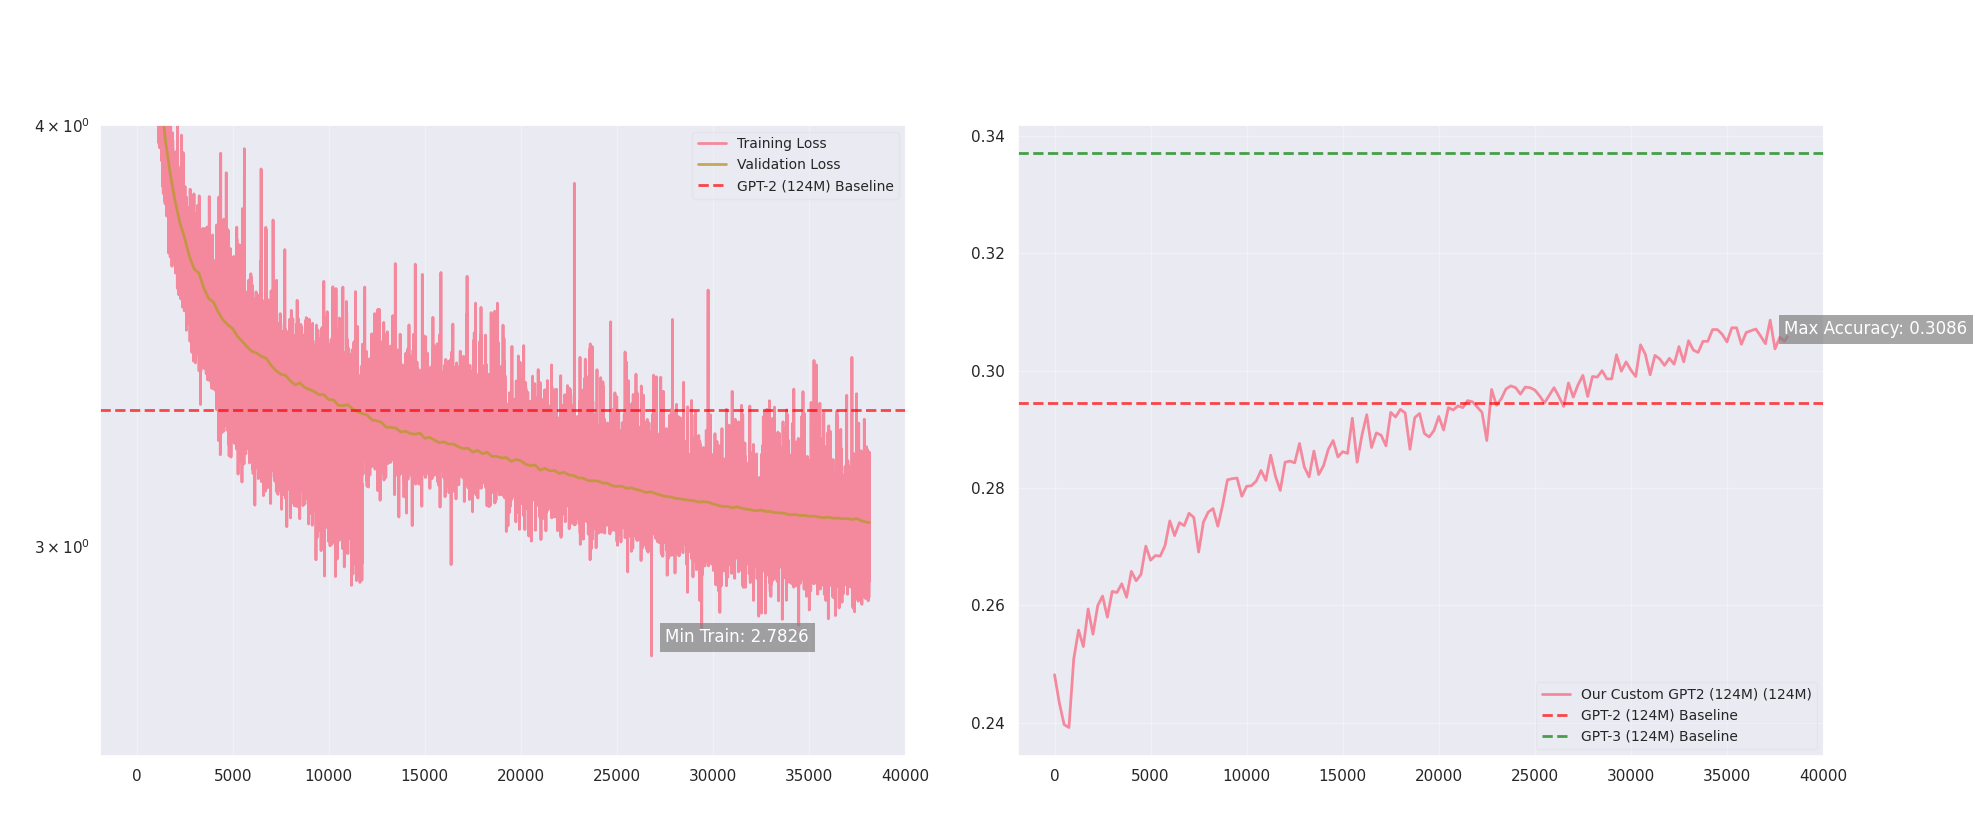


Training Summary for GPT-2 124M:
Minimum Training Loss: 2.7826
Minimum Validation Loss: 3.0481
Maximum HellaSwag Accuracy: 0.3086


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set the style
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

# Create figure with GridSpec
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2, figure=fig)
fig.suptitle(f'Training Metrics for GPT-2 ({sz})', fontsize=16, y=1.02, color='white')

# Load and process data
with open("/content/log/log.txt", "r") as f:
    lines = f.readlines()

streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

streams_xy = {}
for k, v in streams.items():
    xy = sorted(list(v.items()))
    streams_xy[k] = list(zip(*xy))

# Panel 1: Loss curves
ax1 = fig.add_subplot(gs[0])

# Get training and validation data
train_steps, train_losses = streams_xy["train"]
val_steps, val_losses = streams_xy["val"]

# Plot training and validation losses
ax1.plot(train_steps, train_losses, linewidth=2, label='Training Loss', alpha=0.8)
ax1.plot(val_steps, val_losses, linewidth=2, label='Validation Loss', alpha=0.8)

if loss_baseline is not None:
    ax1.axhline(y=loss_baseline, color='red', linestyle='--',
                linewidth=2, label=f'GPT-2 ({sz}) Baseline', alpha=0.7)

ax1.set_xlabel('Training Steps', fontsize=12, color='white')
ax1.set_ylabel('Loss (log scale)', fontsize=12, color='white')
ax1.set_yscale('log')
ax1.set_ylim(top=4.0)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10, framealpha=0.2)
ax1.set_title('Training and Validation Loss', fontsize=14, pad=20, color='white')

# Add min loss annotations
min_train = min(train_losses)
min_val = min(val_losses)
ax1.annotate(f'Min Train: {min_train:.4f}',
             xy=(train_steps[np.argmin(train_losses)], min_train),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(facecolor='gray', edgecolor='none', alpha=0.7),
             color='white')

# Panel 2: HellaSwag evaluation
ax2 = fig.add_subplot(gs[1])
hella_steps, hella_acc = streams_xy["hella"]

ax2.plot(hella_steps, hella_acc, linewidth=2, label=f'Our Custom GPT2 (124M) ({sz})', alpha=0.8)

if hella2_baseline:
    ax2.axhline(y=hella2_baseline, color='red', linestyle='--',
                linewidth=2, label=f'GPT-2 ({sz}) Baseline', alpha=0.7)
if hella3_baseline:
    ax2.axhline(y=hella3_baseline, color='green', linestyle='--',
                linewidth=2, label=f'GPT-3 ({sz}) Baseline', alpha=0.7)

ax2.set_xlabel('Training Steps', fontsize=12, color='white')
ax2.set_ylabel('Accuracy', fontsize=12, color='white')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10, framealpha=0.2)
ax2.set_title('HellaSwag Evaluation', fontsize=14, pad=20, color='white')

# Add max accuracy annotation
max_hella = max(hella_acc)
ax2.annotate(f'Max Accuracy: {max_hella:.4f}',
             xy=(hella_steps[np.argmax(hella_acc)], max_hella),
             xytext=(10, -10), textcoords='offset points',
             bbox=dict(facecolor='gray', edgecolor='none', alpha=0.7),
             color='white')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print metrics
print(f"\nTraining Summary for GPT-2 {sz}:")
print(f"Minimum Training Loss: {min_train:.4f}")
print(f"Minimum Validation Loss: {min_val:.4f}")
print(f"Maximum HellaSwag Accuracy: {max_hella:.4f}")

In this section, we compare the performance of our custom-trained GPT-2 model with the baseline results from both GPT-2 and GPT-3 across several key metrics: training loss, validation loss, and HellaSwag accuracy. This comparison helps us understand how well our model performs relative to established benchmarks.

We begin by defining the baseline training loss for GPT-2 124M, which is 3.2924. This serves as a reference point to evaluate the effectiveness of our training process. After training, our model achieves a minimum training loss of 2.7826,and a minimum validation loss of 3.0481 which is significantly lower than the baseline. This indicates that the model has successfully learned patterns from the training data more effectively than the original GPT-2 implementation.

To assess the model's practical language understanding capabilities, we use the HellaSwag benchmark. For GPT-2 124M, the baseline accuracy is 0.2945, while GPT-3 124M reaches 0.337. Our custom model achieves a maximum accuracy of 0.3086. This result surpasses the GPT-2 baseline but remains below GPT-3’s performance, which is expected given the differences in training scale.

Overall, our model demonstrates significant improvements in training and validation loss compared to GPT-2, along with better accuracy on HellaSwag. While it doesn't match GPT-3’s performance, the results are promising given the computational constraints and training setup.

In [ ]:
import torch
import torch.nn.functional as F
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP

def load_model(checkpoint_path, device='cuda'):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Initialize model with saved config
    model = GPT2(checkpoint['config'])
    model.to(device)

    # Load the state dict
    model.load_state_dict(checkpoint['model'])

    # Put model in eval mode
    model.eval()

    return model

def evaluate_on_val(model, val_loader, device='cuda'):
    model.eval()
    val_loss_accum = 0.0
    val_loss_steps = 20  # Same as in your training code

    with torch.no_grad():
        for _ in range(val_loss_steps):
            x, y = val_loader.next_batch()
            x, y = x.to(device), y.to(device)
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, loss = model(x, y)
            loss = loss / val_loss_steps
            val_loss_accum += loss.detach()

    return val_loss_accum.item()

def generate_text(model, prompt, max_tokens=200, temperature=0.8, top_k=50, device='cuda'):
    model.eval()

    # Encode the prompt
    tokens = enc.encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0)  # Add batch dimension
    x = tokens.to(device)

    # Set up random generator
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(42)

    with torch.no_grad():
        while x.size(1) < len(tokens) + max_tokens:
            # Forward pass
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, _ = model(x)

            # Get logits of the last token and apply temperature
            logits = logits[:, -1, :] / temperature

            # Apply top-k sampling
            probs = F.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, top_k, dim=-1)

            # Sample from the top-k distribution
            idx_next = torch.gather(
                topk_indices,
                -1,
                torch.multinomial(topk_probs, 1, generator=sample_rng)
            )

            # Append to the sequence
            x = torch.cat((x, idx_next), dim=1)

    # Decode the generated sequence
    generated_tokens = x[0].tolist()
    generated_text = enc.decode(generated_tokens)

    return generated_text

# Load the model
model = load_model("log/final_gpt2_124m.pt")

# Evaluate on validation set
val_loss = evaluate_on_val(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

# Generate some text
prompts = [
    "Once upon a time in a distant galaxy,",
    "The secret to happiness is",
    "In the year 2050, artificial intelligence has",
]

print("\nGenerated Samples:")
print("-" * 50)
for prompt in prompts:
    generated = generate_text(
        model,
        prompt=prompt,
        max_tokens=200,
        temperature=0.8
    )
    print(f"\nPrompt: {prompt}")
    print(f"Generated text:\n{generated}")
    print("-" * 50)

<ipython-input-75-f4940cac36f9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Validation Loss: 3.0571

Generated Samples:
--------------------------------------------------

Prompt: Once upon a time in a distant galaxy,
Generated text:
Once upon a time in a distant galaxy, the Milky Way was the brightest and most populated galaxy in the Universe. By far the largest galaxy is NGC 631, which has a diameter of 13 million light-years. NGC 631 is a star-forming region consisting of a cluster of stars that is about the size of our planet and which is currently undergoing a rapid increase in its size. This area is where the stars at NGC 631 are currently being formed. NGC 631 is located in the Local Group, a Group of galaxies that include the Milky Way, the Large Magellanic Cloud, the Local Group, the Local Group, and the Local Group.<|endoftext|>A few months ago, I attended a meeting of the World Health Organization's International Committee on Immunization (ICSI). It was interesting to hear the name of one of the United Nations' health ministers as he described ICSI 

In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a destination directory in your Drive
destination_path = "/content/drive/MyDrive/gpt2_training_124m"
os.makedirs(destination_path, exist_ok=True)

# Copy hellaswag folder
if os.path.exists("/content/hellaswag"):
    shutil.copytree("/content/hellaswag", f"{destination_path}/hellaswag", dirs_exist_ok=True)

# Copy log folder
if os.path.exists("/content/log"):
    shutil.copytree("/content/log", f"{destination_path}/log", dirs_exist_ok=True)

print("Files copied to:", destination_path)
print("\nContents of the destination folder:")
for root, dirs, files in os.walk(destination_path):
    level = root.replace(destination_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files copied to: /content/drive/MyDrive/gpt2_training_124m

Contents of the destination folder:
gpt2_training_124m/
    hellaswag/
        hellaswag_val.jsonl
    log/
        model_25000.pt
        model_05000.pt
        model_38145.pt
        model_15000.pt
        log.txt
        model_35000.pt
        final_gpt2_124m.pt
        model_10000.pt
        model_30000.pt
        model_20000.pt
